Training Set Indices:
[302, 41, 118, 296, 394, 264, 288, 106, 58, 110, 319, 325, 92, 63, 168, 51, 478, 355, 513, 176, 382, 73, 75, 347, 338, 96, 4, 353, 85, 467, 194, 295, 64, 374, 326, 361, 62, 380, 270, 39, 57, 395, 59, 489, 315, 383, 389, 317, 484, 165, 68, 97, 102, 70, 76, 461, 517, 320, 138, 95, 452, 142, 60, 384, 250, 466, 242, 471, 346, 31, 247, 55, 281, 390, 32, 491, 195, 321, 276, 40, 411, 483, 481, 514, 167, 104, 103, 108, 364, 287, 434, 369, 345, 344, 3, 339, 65, 280, 261, 46, 49, 351, 171, 174, 515, 77, 71, 490, 254, 12, 243, 191, 367, 245, 252, 413, 322, 189, 83, 99, 459, 109, 80, 253, 435, 336, 107, 337, 128, 116, 492, 125, 438, 516, 363, 126, 406, 13, 74, 9, 178, 335, 408, 416, 14, 50, 175, 130, 494, 22, 436, 196, 45, 334, 170, 486, 366, 140, 24, 10, 502, 23, 314, 251, 30, 47, 29, 6, 135, 172, 84, 275, 415, 79, 69, 446, 17, 8, 255, 44, 420, 169, 81, 493, 299, 431, 43, 132, 283, 430, 301, 111, 139, 67, 224, 257, 343, 129, 414, 11, 450, 78, 134, 405, 185, 518, 141, 284, 52

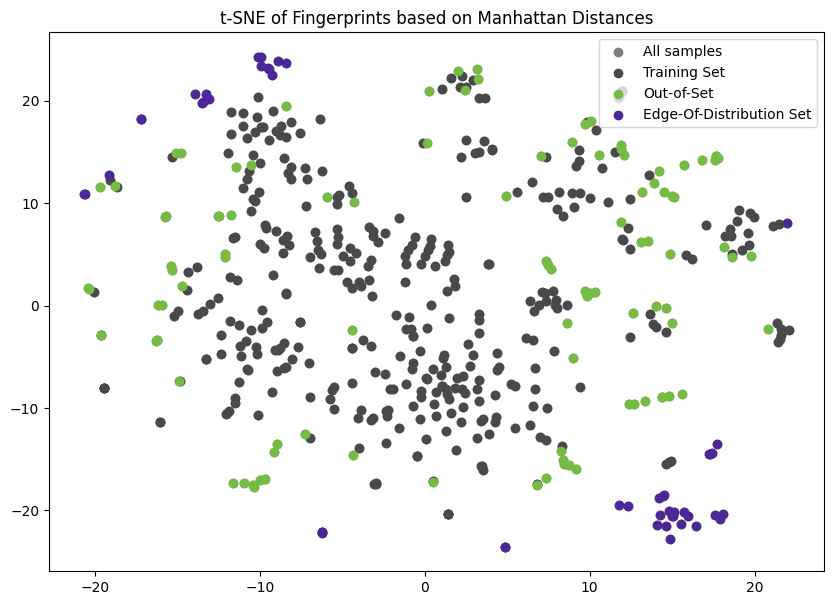

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit import DataStructs
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('MF-class.csv')

# 提取名称和指纹列
names = df.iloc[:, 0]  # 第一列是化合物名称
fingerprints = df.iloc[:, 1:].values  

# 计算Manhattan距离
manhattan_distances = pdist(fingerprints, metric='cityblock')  # 计算曼哈顿距离
manhattan_distance_matrix = squareform(manhattan_distances)  # 转换为方阵形式

# 将指纹转换为位数组
fingerprints_binary = [DataStructs.CreateFromBitString(''.join(map(str, row))) for row in fingerprints]

# 计算Tanimoto相似性矩阵
tanimoto_matrix = np.zeros((len(fingerprints_binary), len(fingerprints_binary)))

for i in range(len(fingerprints_binary)):
    similarities = DataStructs.BulkTanimotoSimilarity(fingerprints_binary[i], fingerprints_binary)
    tanimoto_matrix[i, :] = similarities

# 计算每个分子的平均相似性（与其他分子的相似性均值）
mean_similarities = np.mean(tanimoto_matrix, axis=1)

# 使用 t-SNE 降维
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=2024)
tsne_result = tsne.fit_transform(manhattan_distance_matrix)

# 计算每个样本到 t-SNE 中心的距离
tsne_center = np.mean(tsne_result, axis=0)
distances_to_center = np.linalg.norm(tsne_result - tsne_center, axis=1)

# 按相似性和距离分别排序
sorted_by_similarity = np.argsort(mean_similarities)
sorted_by_distance = np.argsort(distances_to_center)

# 分配数据集大小
num_samples = len(sorted_by_similarity)
external_test_size = int(num_samples * 0.1)  # 库外测试集大小为10%
out_of_test_size = int(num_samples * 0.2)  # 样本外测试集大小为20%

# 选择库外测试集 (选择距离最远的样本)
external_test_indices = sorted_by_distance[-external_test_size:]

# 从剩余的样本中去掉库外测试集样本
remaining_indices = [i for i in sorted_by_similarity if i not in external_test_indices]

# 样本外测试集 (从剩余样本中选择)
out_of_test_indices = remaining_indices[:out_of_test_size]

# 剩下的样本作为训练集
train_indices = remaining_indices[out_of_test_size:]

# 输出训练集、样本外测试集和库外测试集的索引
print("Training Set Indices:")
print(train_indices)

print("\nOut of Test Set Indices:")
print(out_of_test_indices)

print("\nEdge-Of-Distribution Set Indices:")
print(external_test_indices)

# 可视化 t-SNE 结果（可选）
plt.figure(figsize=(10, 7))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], label='All samples', color='gray')
plt.scatter(tsne_result[train_indices, 0], tsne_result[train_indices, 1], color='#494949', label='Training Set')
plt.scatter(tsne_result[out_of_test_indices, 0], tsne_result[out_of_test_indices, 1], color='#75BD42', label='Out-of-Set')
plt.scatter(tsne_result[external_test_indices, 0], tsne_result[external_test_indices, 1], color='#4C2799', label='Edge-Of-Distribution Set')
plt.title('t-SNE of Fingerprints based on Manhattan Distances')
plt.legend()
plt.savefig('./class.png', dpi=600)
plt.show()
